### 2.Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import geohash as gh
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [2]:
df = pd.read_csv("Airbnb_NYC_2019.csv")

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [5]:
df.shape

(48895, 16)

#### 2.1 Dealing with missing values

In [6]:
# check missing values 
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can keep the missing values for `name`, `host_name`, since we are not going to using these variables in the model anyways. Even if we were, it may be worth it to keep them in the model to decide what the output of a null host_name would be.
As for `last_review` and `reviews_per_month`, we believe that `last_month` is a variable that we would never include in the model. For `reviews_per_month`, we can replace all the missing values to 0, because 0 should be the correct value if a review has never been made for that listing.

The empty values for name, host_name, and last reviews can be dropped, since they seem non-menaingful to impute. We can replace the empty values for reviews per month with 0 values, becuase this means there is no review per month. 

In [7]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0.00)
df['name'] = df['name'].fillna('')
df['host_name'] = df['host_name'].fillna('')

In [8]:
#check missing values again 
df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


#### 2.2 Omit extreme outliers and invalid values

There are also be some erroneous values in the dataset. For example, there are instances where the price is 10,000 per day despite being a single private room.

For `price`, we omit from the dataset if the price is above 3,000 per day or costs 0 per day. For `minimum_nights`, we omit if the number of minimum nights is above 60 days per month. For `reviews_per_month`, we omit if the number is above 15 per month, as it is very unlikely a listing could get 15 reviews a month, which is a review every 2 days.

In [11]:
df_omit = df[(df['price'] > 0) & (df['price'] <= 1000) & (df['minimum_nights'] <= 60) & (df['reviews_per_month'] <= 15)]

#### 2.3 What are some components that need to take into considerations for house price?

geography (`latitude`, `longitude`), `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `calculated_host_listings_count`, `availability_365`. Thus we can exclude `id`, `host_id`, `last_review` from our considerations for training data. We also exclude `neigbourhood_group` from our analysis as we believe this too closely overlaps with coordinate data.

In [12]:
# generate training data 
# drop unrelated information
# neighborhood has the same information as latitude and longitude, thus enighborhood can be dropped
df_relevant = df_omit.drop(['id','name', 'host_name', 'host_id','neighbourhood','last_review'], axis=1)

In [13]:
df_relevant.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [14]:
#check number of unique values in each columne to decide what processing technique to use 
df_relevant.nunique()

neighbourhood_group                   5
latitude                          18967
longitude                         14664
room_type                             3
price                               569
minimum_nights                       50
number_of_reviews                   391
reviews_per_month                   927
calculated_host_listings_count       47
availability_365                    366
dtype: int64

#### 2.4 One hot encoding for categorical variables

In [15]:
print(df_relevant['room_type'].unique())
print(df_relevant['neighbourhood_group'].unique())

['Private room' 'Entire home/apt' 'Shared room']
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


Based on the number of unique values and data type for each column. We can apply the following encoding method for text preprocessing: 

1. one hot encoding for neighbor group
2. create grouping for latitude and longitude first? then encode?
3.label encode for room type since size matters
4. conduct normalization/ standardization for all continuous data

In [16]:
#exclude label
df_relevant.drop(['price'], axis = 1, inplace= True)

In [17]:
df_relevant.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0


In [18]:
df_relevant_encode = pd.get_dummies(df_relevant, prefix = ['neighbourhood_group', 'room_type'], columns = ['neighbourhood_group', 'room_type'])
df_relevant_label = pd.get_dummies(df_relevant, prefix = ['neighbourhood_group'], columns = ['neighbourhood_group'])
le = preprocessing.LabelEncoder()
le.fit(['Shared room','Private room','Entire home/apt'])
df_relevant_label['room_type'] = le.transform(df_relevant_label['room_type'])

#### 2.5 Geohash for latitude and longitude

In [19]:
# create geohash code for geographical data 
df_relevant_encode['geohash']=df_relevant_encode.apply(lambda x: gh.encode(x['latitude'], x['longitude'], precision=7), axis=1)

In [20]:
df_relevant_encode.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,geohash
0,40.64749,-73.97237,1,9,0.21,6,365,0,1,0,0,0,0,1,0,dr5rhxw
1,40.75362,-73.98377,1,45,0.38,2,355,0,0,1,0,0,1,0,0,dr5ru6y
2,40.80902,-73.94190,3,0,0.00,1,365,0,0,1,0,0,0,1,0,dr72jmj
3,40.68514,-73.95976,1,270,4.64,1,194,0,1,0,0,0,1,0,0,dr5rmn8
4,40.79851,-73.94399,10,9,0.10,1,0,0,0,1,0,0,1,0,0,dr72j75


In [21]:
#drop latltitude longitude
df_relevant_encode.drop(['latitude', 'longitude'], axis = 1, inplace= True)

In [22]:
df_relevant_encode.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,geohash
0,1,9,0.21,6,365,0,1,0,0,0,0,1,0,dr5rhxw
1,1,45,0.38,2,355,0,0,1,0,0,1,0,0,dr5ru6y
2,3,0,0.00,1,365,0,0,1,0,0,0,1,0,dr72jmj
3,1,270,4.64,1,194,0,1,0,0,0,1,0,0,dr5rmn8
4,10,9,0.10,1,0,0,0,1,0,0,1,0,0,dr72j75


In [23]:
df_relevant_encode.geohash.nunique()
# there are 10442 unique geographical location, should apply target encoding later

10431

In [24]:
X_col_names = df_relevant_encode.columns
X = df_relevant_encode.values.tolist()
y = df_omit['price'].tolist()

#### 2.3 Split Train and Test Data (2/3, 1/3 split)

Split train data and test data for this one, with 67% in the training set and 33% in the testing set.

In [25]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

32373
15946
32373
15946


In [26]:
#create train and test dataframe for target encoding later
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)
df_train.columns = X_col_names
df_test.columns = X_col_names

#### 2.4 Transform Continuous Variables

Use `TargetEncoder` to encode the `geohash`. Also, transform the y-variable and x-variables if necessary into either normalized/standardized form.

Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

In [27]:
# target encode on geolocations, since the amount of unique values are large
# if we look at price as a target, each row with the unique value of geolocation would be replaced with the average price for the house
encoder = ce.TargetEncoder(cols=['geohash'], smoothing=0, return_df=True)

df_train['coded_geo'] = encoder.fit_transform(df_train['geohash'], y_train)
df_test['coded_geo'] = encoder.transform(df_train['geohash'])

/Users/cookiepoon/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [28]:
df_train.drop('geohash', axis=1, inplace= True)
df_test.drop('geohash', axis=1, inplace= True)

It turns out the y-variable could benefit from a log transformation, depending on what model we are using as the distribution of prices is close to a lognormal distribution.

In [340]:
#one, two, three = stats.boxcox(y_train, alpha = 0.95)
# print(three)
# y_train = np.log(y_train)
# y_test = np.log(y_test)

(-0.21245489163451545, -0.2116241203325513)


In [29]:
# concatenate train and test dataframes again for normalization or stanadardization
df_train['price'] = y_train
df_test['price'] = y_test
df_whole = pd.concat([df_train, df_test])

In [30]:
# apply standarization or normalization on continuous values based on the data distribution
to_scale = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365','coded_geo']
scaled_train = df_train.copy()
scaled_test = df_test.copy()
scaled_features = scaled_train[to_scale]
scaler = preprocessing.StandardScaler().fit(scaled_features)
scaled_train[to_scale] = scaler.transform(scaled_features)
scaled_test[to_scale] = scaler.transform(scaled_test[to_scale])

In [343]:
# This is extra code in case room_type uses the label encode instead of one-hot encoding
# scaler2 = preprocessing.StandardScaler().fit(df_relevant_label['room_type'].values.reshape(-1,1))
# df_relevant_label['room_type'] = scaler2.transform(df_relevant_label['room_type'].values.reshape(-1,1))

In [31]:
print(scaler.mean_, scaler.var_)
# print(scaler2.mean_, scaler2.var_)

[  5.90578569  23.45883916   1.0982646    7.14419424 111.87177586
 145.06139662] [7.97672334e+01 1.97257864e+03 2.45885778e+00 1.07521505e+03
 1.72229072e+04 4.35186541e+03]


In [32]:
scaled_train.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
count,3.237300e+04,3.237300e+04,3.237300e+04,3.237300e+04,3.237300e+04,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000,32373.000000,3.237300e+04,32373.000000
mean,-5.897560e-16,-2.222847e-16,7.928357e-16,1.951104e-16,-6.364037e-16,0.023044,0.411701,0.439317,0.118463,0.007475,0.516511,0.460075,0.023415,1.007733e-16,141.079480
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,0.150045,0.492149,0.496312,0.323160,0.086138,0.499735,0.498411,0.151219,1.000015e+00,116.212547
min,-5.492832e-01,-5.281890e-01,-7.003906e-01,-1.873774e-01,-8.524468e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.895770e+00,10.000000
25%,-5.492832e-01,-5.056734e-01,-6.748816e-01,-1.873774e-01,-8.524468e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.096004e-01,69.000000
50%,-4.373168e-01,-4.156112e-01,-4.580551e-01,-1.873774e-01,-5.171732e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-6.036073e-02,105.000000
75%,-1.014176e-01,1.218454e-02,3.263463e-01,-1.568808e-01,8.544009e-01,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4.704330e-01,175.000000
max,6.056735e+00,1.363410e+01,8.597637e+00,9.754535e+00,1.928801e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.973026e+00,1000.000000


In [33]:
scaled_test.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
count,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000,15946.00000,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000,15946.000000
mean,-0.008796,-0.004718,-0.005474,0.000772,0.000561,0.020758,0.414399,0.444187,0.11263,0.008027,0.519127,0.456541,0.024332,0.004287,141.892638
std,0.980365,1.007051,0.986433,1.021041,0.999243,0.142576,0.492633,0.496891,0.31615,0.089237,0.499650,0.498123,0.154083,0.999950,118.074721
min,-0.549283,-0.528189,-0.700391,-0.187377,-0.852447,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.895770,10.000000
25%,-0.549283,-0.505673,-0.674882,-0.187377,-0.852447,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.704295,69.000000
50%,-0.325350,-0.415611,-0.458055,-0.187377,-0.524793,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,-0.060361,105.000000
75%,-0.101418,0.012185,0.326346,-0.156881,0.862021,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.478843,175.000000
max,6.056735,13.138759,8.623146,9.754535,1.928801,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,8.973026,1000.000000


In [34]:
# correlation plot to decide variables 
scaled_train.corr()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
minimum_nights,1.000000,-0.147990,-0.223799,0.308940,0.233287,-0.044966,-0.068389,0.118120,-0.051498,-0.018318,0.137614,-0.132417,-0.018334,0.095232,0.038798
number_of_reviews,-0.147990,1.000000,0.595509,-0.074129,0.177020,0.007786,0.017814,-0.045826,0.035401,0.015882,-0.000076,0.006629,-0.021598,-0.053203,-0.056272
reviews_per_month,-0.223799,0.595509,1.000000,-0.051926,0.171753,0.035298,-0.022078,-0.065375,0.110712,0.025982,-0.022020,0.021825,0.000834,-0.069650,-0.056097
calculated_host_listings_count,0.308940,-0.074129,-0.051926,1.000000,0.230374,-0.022763,-0.123997,0.153666,-0.033151,-0.012915,0.111875,-0.108345,-0.012617,0.187275,0.132569
availability_365,0.233287,0.177020,0.171753,0.230374,1.000000,0.060805,-0.079609,-0.005056,0.086739,0.052646,-0.009922,-0.007118,0.056250,0.052416,0.119138
neighbourhood_group_Bronx,-0.044966,0.007786,0.035298,-0.022763,0.060805,1.000000,-0.128479,-0.135947,-0.056300,-0.013329,-0.054511,0.043696,0.036123,-0.051393,-0.074819
neighbourhood_group_Brooklyn,-0.068389,0.017814,-0.022078,-0.123997,-0.079609,-0.128479,1.000000,-0.740495,-0.306664,-0.072600,-0.066073,0.072050,-0.019122,-0.298862,-0.165228
neighbourhood_group_Manhattan,0.118120,-0.045826,-0.065375,0.153666,-0.005056,-0.135947,-0.740495,1.000000,-0.324490,-0.076820,0.154089,-0.151875,-0.008644,0.438289,0.287236
neighbourhood_group_Queens,-0.051498,0.035401,0.110712,-0.033151,0.086739,-0.056300,-0.306664,-0.324490,1.000000,-0.031814,-0.109761,0.101958,0.026679,-0.186135,-0.146237
neighbourhood_group_Staten Island,-0.018318,0.015882,0.025982,-0.012915,0.052646,-0.013329,-0.072600,-0.076820,-0.031814,1.000000,-0.003585,0.004793,-0.003952,-0.029956,-0.032014


In [35]:
scaled_train_X = scaled_train.loc[:, scaled_train.columns != 'price'].values.tolist()
scaled_train_y = scaled_train['price'].tolist()

scaled_test_X = scaled_test.loc[:, scaled_train.columns != 'price'].values.tolist()
scaled_test_y = scaled_test['price'].tolist()

### 3.Model training

In [36]:
# some helper functions to do plotting 
# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

#### 3.1  Quick linear model for baseline
* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

In [37]:
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

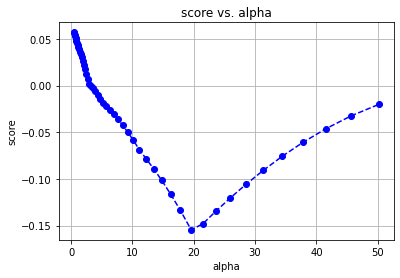

The optimaized alpha and score of Lasso linear is:  0.5011872336272722 0.05714161976742538
0.5011872336272722


In [38]:
# Lasso model select the optimized hyperparameters
alphas = np.logspace (-0.3, 1.7, num=50)
#Return numbers spaced evenly on a log scale.
scores = np.empty_like(alphas)

opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(scaled_train_X, scaled_train_y)
    scores[i] = lasso.score(scaled_test_X, scaled_test_y) # get scores for test dataset
    # lasso.score() Return the coefficient of determination R^2 of the prediction.
    # The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
    # A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)
print(opt_a)

In [39]:
# use  optimal alpha, re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(scaled_train_X, scaled_train_y)
lasso_pred = lasso_f.predict(scaled_test_X)

In [60]:
pip install yellowbrick

     |████████████████████████████████| 271 kB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [67]:
import yellowbrick
from yellowbrick.regressor import PredictionError


In [97]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_devation(arr):
    # Calculate the sum of absolute deviation about mean.
    absSum = 0
    for i in range(0, len(arr)):
        absSum = absSum + abs(arr[i] - np.mean(arr))
    return absSum / len(arr)

def mean_absolute_deviation_ratio(y_true, y_pred):
    return mean_absolute_devation(y_pred)/(mean_absolute_devation(y_true)+0.1)

def evaluate(test_price, prediction):
    MAPE = mean_absolute_percentage_error(test_price,prediction)
    print ('MAPE of 2019 Airbnb price is {}'.format(MAPE))  
    MAE = mean_absolute_error(test_price, prediction)
    print ('MAE of 2019 Airbnb price is {}'.format(MAE))   
    MAD_ratio = mean_absolute_deviation_ratio(test_price,prediction)
    print ('MAD ratio of prediction in 2019 Airbnb price is {}'.format(MAD_ratio))
 
    
def plot_diff(test_price, prediction, title1, title2):    # plot the pred vs. actual
    plt.plot(prediction,'o', color='red', alpha=0.3, label = 'predicted price')
    plt.plot(test_price,'*', color='blue', alpha=0.5, label = 'actual price')
    plt.title(title1)
    plt.legend(loc='upper right')
    plt.show()

    plt.plot((prediction - test_price)
             ,'v', color='green')
    plt.title(title2)
    plt.show()

def visualize_diff(test_price, prediction, model_name):
    plt.plot(test_price, color = "red", alpha=0.3, label = 'actual price')
    plt.plot(prediction, color = "green", alpha=0.5, label = 'predicted_price' )
    plt.title("Pred vs. Actual in {}".format(model_name))
    plt.legend(loc="upper right")
    plt.show()

In [41]:
evaluate(scaled_test_y, lasso_pred)

MAPE of 2019 Airbnb price is 64.62376985946709
MAE of 2019 Airbnb price is 72.74103236609145
MAD ratio of prediction in 2019 Airbnb price is 0.6511836804771372


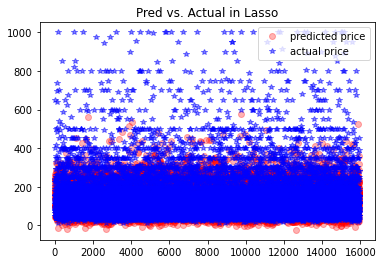

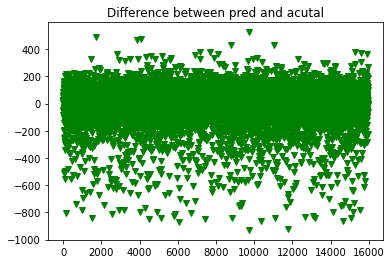

In [42]:
plot_diff(scaled_test_y, lasso_pred, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

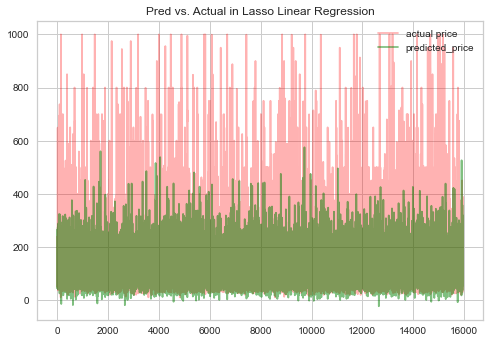

In [98]:
visualize_diff(scaled_test_y, lasso_pred, "Lasso Linear Regression")

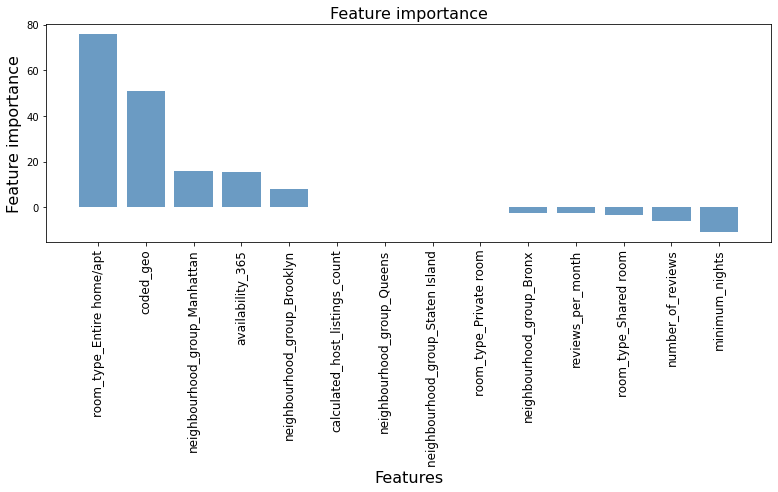

In [43]:
# get important features from linear regression
importance_lr_best = lasso_f.coef_
names_lr_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_lr_best = pd.DataFrame({'Feature':names_lr_best, 'Importance':importance_lr_best})
# plot feature importance
rank_importance_lr_best = df_importantce_lr_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_lr_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.2 KNN

In [44]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [45]:
parameters = { 'n_neighbors':[2,3,4,5,6,7,8,9] 
}
Grid_KNN = GridSearchCV(KNeighborsRegressor(),parameters, cv=5)
Grid_KNN.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.4542135964565836
Best parameters set:
n_neighbors:9


In [46]:
knn_pred = best_KNN_model.predict(scaled_test_X)

In [47]:
evaluate(scaled_test_y, knn_pred)

MAPE of 2019 Airbnb price is 53.673966815195485
MAE of 2019 Airbnb price is 67.20335995094555
MAD ratio of prediction in 2019 Airbnb price is 0.7290238812681127


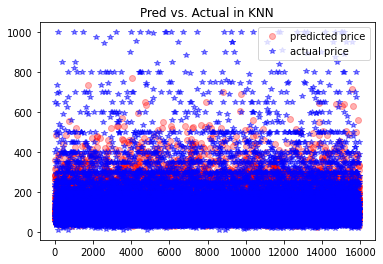

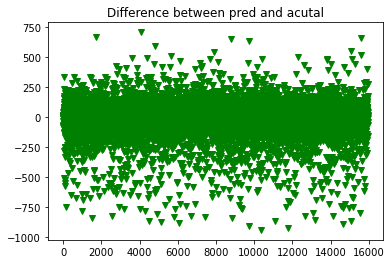

In [48]:
plot_diff(scaled_test_y, knn_pred, 'Pred vs. Actual in KNN', 'Difference between pred and acutal')

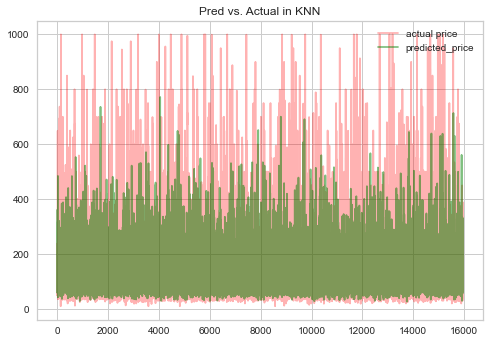

In [99]:
visualize_diff(scaled_test_y, knn_pred, "KNN")

In [ ]:
# perform permutation importance
from sklearn.inspection import permutation_importance
knn_results = permutation_importance(best_KNN_model, scaled_test_X, scaled_test_y, scoring='neg_mean_squared_error')
importance = knn_results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

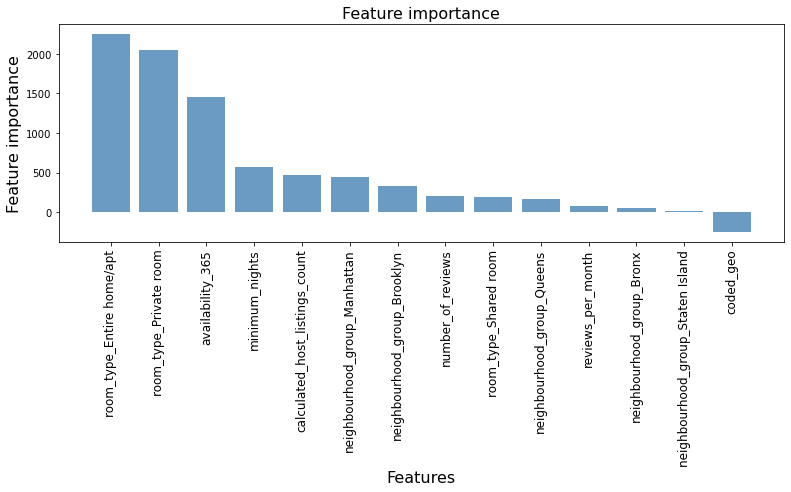

In [49]:
# get important features from knn
from sklearn.inspection import permutation_importance
knn_results = permutation_importance(best_KNN_model, scaled_test_X, scaled_test_y, scoring='neg_mean_squared_error')
importance_knn_best = knn_results.importances_mean
names_knn_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_knn_best = pd.DataFrame({'Feature':names_knn_best, 'Importance':importance_knn_best})
# plot feature importance
rank_importance_knn_best = df_importantce_knn_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_knn_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.3 SVM

In [50]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear']}  
  
Grid_SVM = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3, cv =5) 


Grid_SVM.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_SVM)
best_SVM_model = Grid_SVM.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time=  41.7s
[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time=  39.3s
[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time=  39.9s
[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time=  38.9s
[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time=  39.0s
[CV 1/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=  38.6s
[CV 2/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=  38.9s
[CV 3/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=  38.7s
[CV 4/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=  38.7s
[CV 5/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=  40.7s
[CV 1/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=  39.1s
[CV 2/5] END ...............C=0.1, gamma=0.01, k

In [51]:
svm_pred = best_SVM_model.predict(scaled_test_X)

In [76]:
evaluate(scaled_test_y, svm_pred)

MAPE of 2019 Airbnb price is 47.61686821161737
MAE of 2019 Airbnb price is 67.49290143854046
MAD ratio of prediction in 2019 Airbnb price is 0.47446863788451904


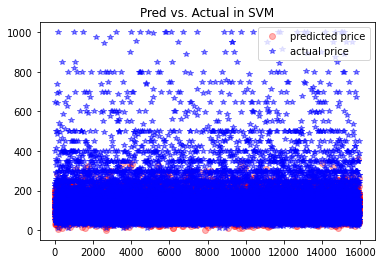

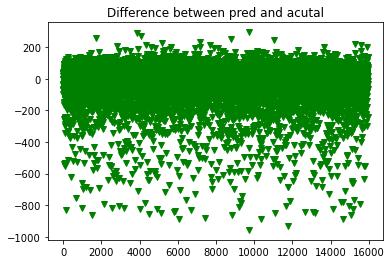

In [52]:
plot_diff(scaled_test_y, svm_pred, 'Pred vs. Actual in SVM', 'Difference between pred and acutal')

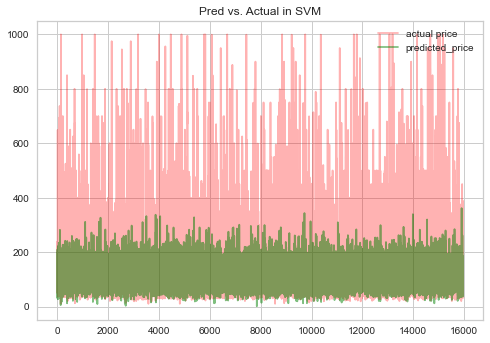

In [100]:
visualize_diff(scaled_test_y, svm_pred, "SVM")

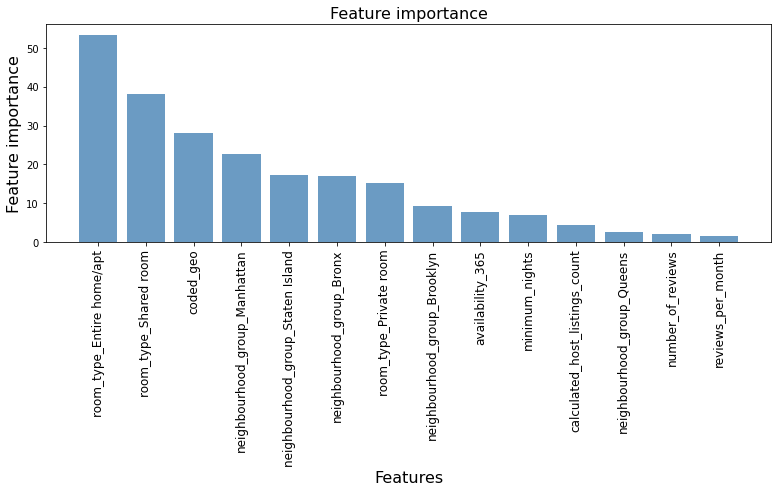

In [53]:
# get important features from SVM
importance_svm_best = abs(best_SVM_model.coef_[0])
names_svm_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_svm_best = pd.DataFrame({'Feature':names_svm_best, 'Importance':importance_svm_best})
# plot feature importance
rank_importance_svm_best = df_importantce_svm_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_svm_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.4 Random Forest Regression

In [54]:
param_grid = {'n_estimators': [5,10,15,20,30,40],
          'max_depth': [30,40,45,50,55,60]}  
  
Grid_RF = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, refit = True, verbose = 3, cv =5) 


Grid_RF.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ...................max_depth=30, n_estimators=5; total time=   0.7s
[CV 2/5] END ...................max_depth=30, n_estimators=5; total time=   0.6s
[CV 3/5] END ...................max_depth=30, n_estimators=5; total time=   0.6s
[CV 4/5] END ...................max_depth=30, n_estimators=5; total time=   0.6s
[CV 5/5] END ...................max_depth=30, n_estimators=5; total time=   0.7s
[CV 1/5] END ..................max_depth=30, n_estimators=10; total time=   1.7s
[CV 2/5] END ..................max_depth=30, n_estimators=10; total time=   1.5s
[CV 3/5] END ..................max_depth=30, n_estimators=10; total time=   1.6s
[CV 4/5] END ..................max_depth=30, n_estimators=10; total time=   1.2s
[CV 5/5] END ..................max_depth=30, n_estimators=10; total time=   1.2s
[CV 1/5] END ..................max_depth=30, n_estimators=15; total time=   1.8s
[CV 2/5] END ..................max_depth=30, n_

In [55]:
best_RF_model.fit(scaled_train_X, scaled_train_y)
rf_pred = best_RF_model.predict(scaled_test_X)

In [86]:
evaluate(scaled_test_y, rf_pred)

MAPE of 2019 Airbnb price is 67.96087708483496
MAE of 2019 Airbnb price is 83.9322603416894
MAD ratio of prediction in 2019 Airbnb price is 0.8116027940550739


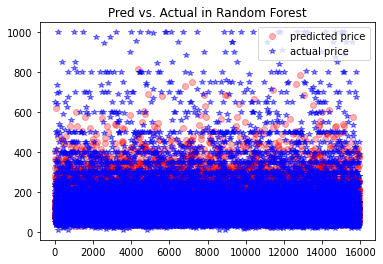

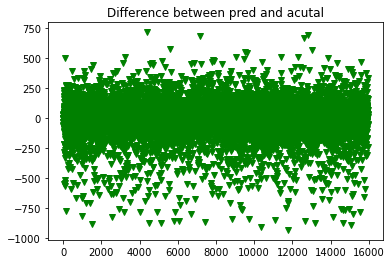

In [56]:
plot_diff(scaled_test_y, rf_pred, 'Pred vs. Actual in Random Forest', 'Difference between pred and acutal')

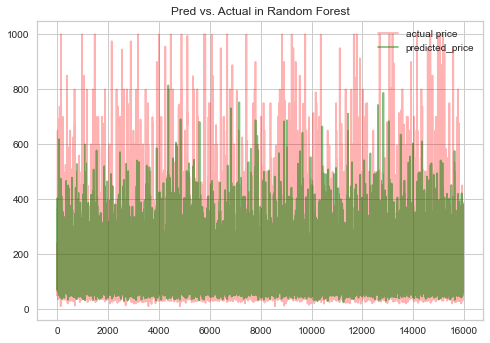

In [101]:
visualize_diff(scaled_test_y, rf_pred, "Random Forest")

14
14


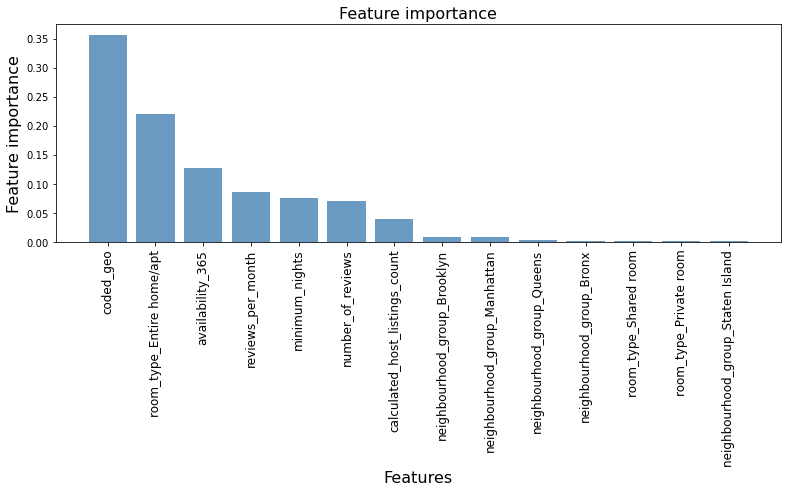

In [57]:
importance_rf_best = best_RF_model.feature_importances_
names_rf_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()
print(len(names_rf_best))
print(len(importance_rf_best))
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})
# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')